<a href="https://colab.research.google.com/github/rename-z/Deep-Learning/blob/master/Zero%20to%20GANs/Feed%20Forward%20Neural%20Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Training Deep Neural Networks on a GPU with PyTorch**

In [1]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline

In [2]:
dataset = MNIST(root='/content', download=True, transform=ToTensor())

Extracting /content/MNIST/raw/train-images-idx3-ubyte.gz to /content/MNIST/raw


Extracting /content/MNIST/raw/train-labels-idx1-ubyte.gz to /content/MNIST/raw



Extracting /content/MNIST/raw/t10k-images-idx3-ubyte.gz to /content/MNIST/raw


Extracting /content/MNIST/raw/t10k-labels-idx1-ubyte.gz to /content/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [3]:
val_size = 10000
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(50000, 10000)

In [4]:
batch_size = 128

In [5]:
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

images.shape: torch.Size([128, 1, 28, 28])


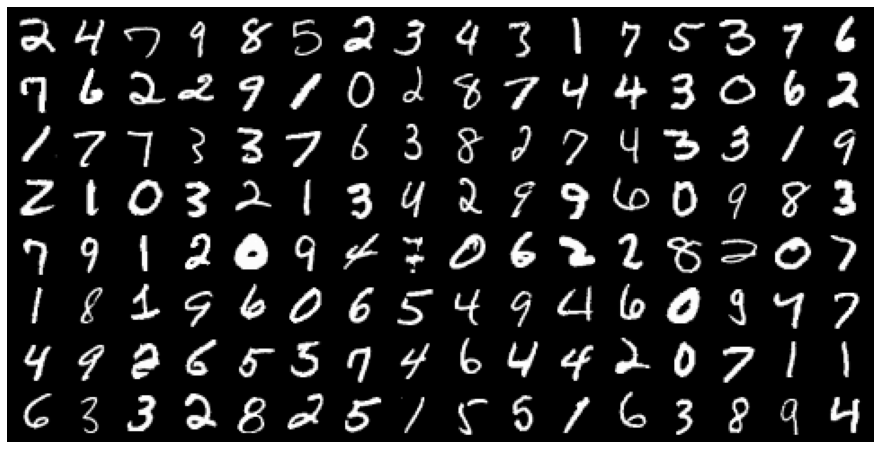

In [6]:
for images, _ in train_loader :
  print('images.shape:',images.shape)
  plt.figure(figsize=(16, 8))
  plt.axis('off')
  plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
  break

In [7]:
def accuracy(outputs, labels) :
  _, preds = torch.max(outputs, dim=1)
  return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [8]:
class MnistModel(nn.Module) :
  """Feed Forward Neural Network with 1 hidden layer"""
  def __init__(self, in_features, hidden_size, out_features) :
    super().__init__()
    self.linear1 = nn.Linear(in_features, hidden_size)
    self.linear2 = nn.Linear(hidden_size, out_features)

  def forward(self, xb) :
    xb = xb.view(xb.size(0), -1)
    out = self.linear1(xb)
    out = F.relu(out)
    out = self.linear2(out)
    return out

  def training_step(self, batch) :
    images, labels = batch
    out = self(images)
    loss = F.cross_entropy(out, labels)
    return loss
  
  def validation_step(self, batch) :
    images, labels = batch
    out = self(images)
    loss = F.cross_entropy(out, labels)
    acc = accuracy(out, labels)
    return {'val_loss': loss, 'val_acc': acc}

  def validation_epoch_end(self, outputs) :
    batch_losses = [x['val_loss'] for x in outputs]
    epoch_losses = torch.stack(batch_losses).mean()
    batch_acc = [x['val_acc'] for x in outputs]
    epoch_acc = torch.stack(batch_acc).mean()
    return {'val_loss': epoch_losses.item(), 'val_acc': epoch_acc.item()}

  def epoch_end(self, epoch, result) :
    print(f'Epoch [{epoch}], val_loss : {result["val_loss"]:.4f}, val_acc : {result["val_acc"]:.4f}') 

In [9]:
in_features = 1*28*28
hidden_size = 32
out_features = 10

In [10]:
model = MnistModel(in_features, hidden_size, out_features)

In [11]:
for t in model.parameters() :
  print(t.shape)

torch.Size([32, 784])
torch.Size([32])
torch.Size([10, 32])
torch.Size([10])


In [12]:
for images, labels in train_loader :
  outputs = model(images)
  loss = F.cross_entropy(outputs, labels)
  print('loss : ', loss)
  break

print('outputs shape : ', outputs.shape)
print('outputs : \n', outputs[:2])

loss :  tensor(2.3132, grad_fn=<NllLossBackward>)
outputs shape :  torch.Size([128, 10])
outputs : 
 tensor([[-0.1282, -0.1551, -0.1086,  0.1211, -0.0455, -0.0891, -0.0076, -0.1927,
         -0.0695,  0.2111],
        [-0.1789, -0.1482, -0.0666,  0.2173,  0.0158, -0.1795, -0.0298, -0.1695,
          0.0038,  0.1839]], grad_fn=<SliceBackward>)


### *Using GPU*

In [13]:
torch.cuda.is_available()

True

In [14]:
def get_default_device() :
  """pick GPU if available, else CPU"""
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')

In [15]:
device = get_default_device()
device

device(type='cuda')

In [16]:
def to_device(data, device) :
  """Move tensor(s) to choosen device"""
  if isinstance(data, (list,tuple)) :
    return [to_device(x, device) for x in data]
  return data.to(device, non_blocking=True)

In [17]:
for images, labels in train_loader :
  print(images.shape)
  images = to_device(images, device)
  print(images.device)
  break

torch.Size([128, 1, 28, 28])
cuda:0


In [18]:
class DeviceDataLoader() :
  """wrap a dataloader to move data to a device"""
  def __init__(self, dl, device):
    self.dl = dl
    self.device = device

  def __iter__(self):
    """yield a batch of data after moving it to device"""
    for b in self.dl:
      yield to_device(b, self.device)
  
  def __len__(self):
    """Number of batches"""
    return len(self.dl)

In [19]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)

In [20]:
for xb, yb in val_loader :
  print('xb.device : ', xb.device)
  print('yb : ', yb)
  break

xb.device :  cuda:0
yb :  tensor([4, 6, 5, 4, 0, 1, 6, 2, 1, 3, 4, 3, 7, 0, 4, 7, 0, 5, 5, 7, 4, 4, 4, 8,
        3, 0, 8, 8, 1, 2, 2, 7, 7, 6, 4, 8, 9, 6, 9, 0, 2, 0, 5, 3, 0, 8, 7, 7,
        5, 7, 5, 0, 8, 0, 8, 5, 1, 1, 8, 2, 9, 1, 9, 4, 2, 6, 6, 9, 8, 6, 1, 8,
        1, 2, 3, 5, 0, 6, 4, 5, 1, 8, 0, 2, 3, 3, 9, 3, 5, 1, 4, 9, 2, 8, 1, 5,
        2, 1, 3, 5, 8, 1, 5, 2, 5, 2, 7, 0, 2, 4, 4, 5, 9, 6, 8, 5, 4, 2, 3, 1,
        1, 9, 8, 8, 1, 7, 1, 4, 5, 0, 3, 7, 5, 7, 6, 8, 6, 3, 7, 5, 6, 3, 2, 2,
        0, 0, 1, 1, 1, 4, 3, 8, 8, 0, 7, 4, 6, 5, 5, 3, 1, 6, 0, 0, 9, 1, 3, 4,
        3, 2, 3, 3, 1, 8, 9, 2, 0, 3, 5, 2, 7, 9, 4, 4, 5, 0, 5, 7, 3, 0, 9, 6,
        0, 3, 4, 2, 6, 5, 4, 4, 9, 1, 3, 0, 1, 2, 3, 5, 0, 2, 8, 2, 6, 8, 4, 0,
        8, 0, 8, 1, 8, 3, 5, 5, 5, 1, 4, 7, 4, 1, 0, 5, 2, 2, 8, 9, 9, 3, 8, 0,
        6, 7, 2, 8, 0, 6, 5, 2, 9, 7, 3, 8, 0, 6, 6, 0], device='cuda:0')


### *Training the Model*

In [28]:
def evaluate(model, val_loader) :
  outputs = [model.validation_step(batch) for batch in train_loader]
  return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
  history = []
  optimizer = opt_func(model.parameters(), lr)
  for epoch in range(epochs) :
    for batch in train_loader :
      loss = model.training_step(batch)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

    result = evaluate(model, val_loader)
    model.epoch_end(epoch, result)
    history.append(result)
  return history

In [22]:
model = MnistModel(in_features, hidden_size, out_features)
to_device(model, device)

MnistModel(
  (linear1): Linear(in_features=784, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=10, bias=True)
)

In [26]:
history = [evaluate(model, val_loader)]
history

[{'val_acc': 0.9412603974342346, 'val_loss': 0.20756487548351288}]

In [29]:
history += fit(5, 0.5, model, train_loader, val_loader)

Epoch [0], val_loss : 0.1334, val_acc : 0.9605
Epoch [1], val_loss : 0.0991, val_acc : 0.9709
Epoch [2], val_loss : 0.0855, val_acc : 0.9747
Epoch [3], val_loss : 0.0825, val_acc : 0.9752
Epoch [4], val_loss : 0.0712, val_acc : 0.9787


In [30]:
history += fit(5, 0.1, model, train_loader, val_loader)

Epoch [0], val_loss : 0.0583, val_acc : 0.9833
Epoch [1], val_loss : 0.0568, val_acc : 0.9840
Epoch [2], val_loss : 0.0553, val_acc : 0.9842
Epoch [3], val_loss : 0.0534, val_acc : 0.9848
Epoch [4], val_loss : 0.0528, val_acc : 0.9855


Text(0.5, 1.0, 'Loss vs No. of epochs')

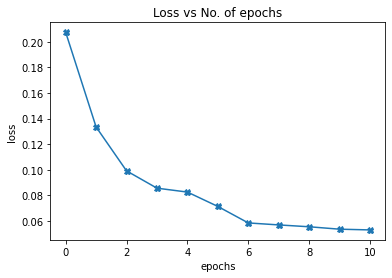

In [34]:
losses = [x['val_loss'] for x in history]
plt.plot(losses, '-X')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('Loss vs No. of epochs')

Text(0.5, 1.0, 'Accuracy vs No. of epochs')

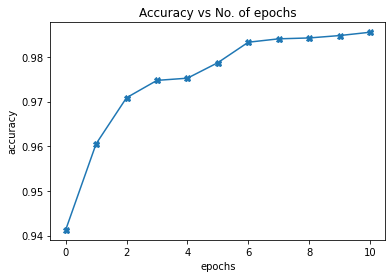

In [35]:
losses = [x['val_acc'] for x in history]
plt.plot(losses, '-X')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('Accuracy vs No. of epochs')